In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
from google.colab import files
import io

uploaded = files.upload()
load= pd.read_csv(io.BytesIO(uploaded['zapo.csv']))

KeyError: ignored

In [105]:
load['Date'] = pd.to_datetime(load['Date'])
load.set_index('Date', inplace=True)

KeyError: ignored

In [106]:
load = load.dropna()

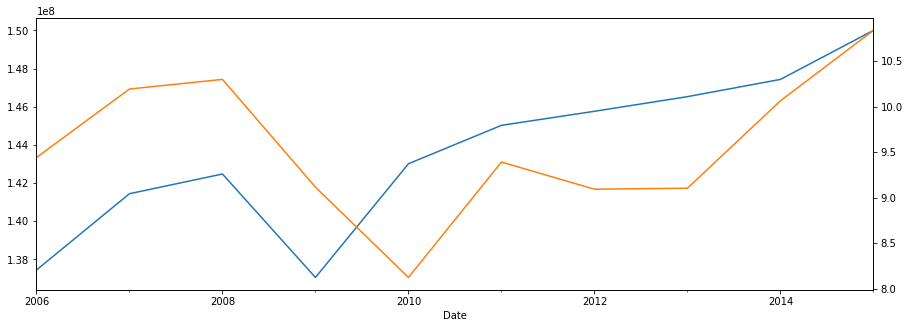

In [107]:
fig = plt.figure(figsize=(15,5))
ax_ = fig.add_subplot(1,1,1)


load.resample('1Y').sum()['load'].plot(ax = ax_)
load.resample('1Y').mean()['temp'].plot(ax = ax_, secondary_y = True)

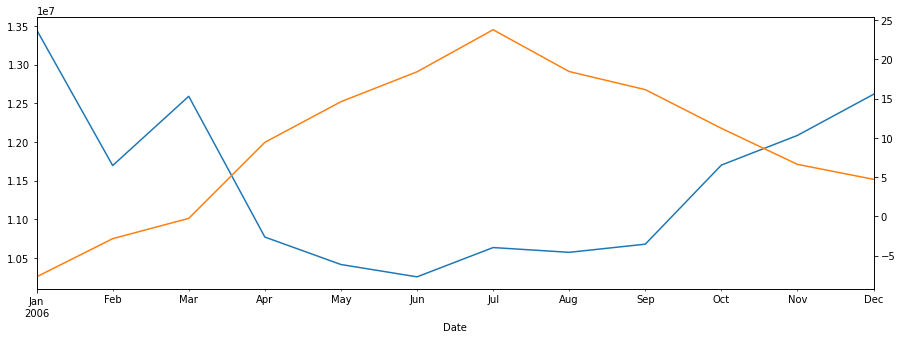

In [56]:
fig = plt.figure(figsize=(15,5))
ax_ = fig.add_subplot(1,1,1)


load_year = load.loc['2006']
load_year.resample('1M').sum()['load'].plot(ax = ax_)
load_year.resample('1M').mean()['temp'].plot(ax = ax_, secondary_y = True)

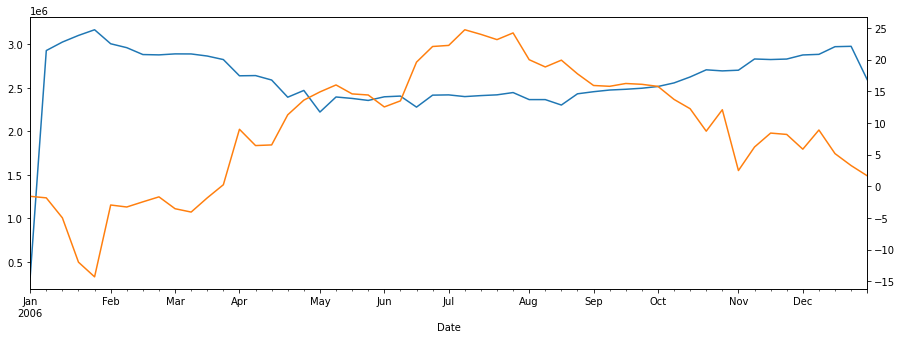

In [57]:
fig = plt.figure(figsize=(15,5))
ax_ = fig.add_subplot(1,1,1)


load_year = load.loc['2006']
load_year.resample('1W').sum()['load'].plot(ax = ax_)
load_year.resample('1W').mean()['temp'].plot(ax = ax_, secondary_y = True)


In [60]:
df_norm = load.copy()

load_min, load_max = load['load'].min(), load['load'].max()
temp_min, temp_max = load['temp'].min(), load['temp'].max()

df_norm['load'] = (load['load'] - load_min) / (load_max - load_min)
df_norm['temp'] = (load['temp'] - temp_min) / (temp_max - temp_min)

df_norm.head()

,Unnamed: 0.1,Unnamed: 0.1.1,load,temp
Date,,,,
2006-01-01 00:00:00,0,0,0.365654,0.395085
2006-01-01 01:00:00,1,1,0.320995,0.395085
2006-01-01 02:00:00,2,2,0.282438,0.395085
2006-01-01 03:00:00,3,3,0.254208,0.395085
2006-01-01 04:00:00,4,4,0.239925,0.395085


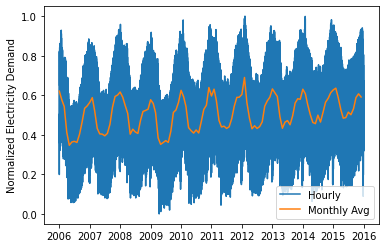

In [61]:

monthly_norm = df_norm['load'].resample('MS').mean().bfill()
plt.plot(df_norm['load'], label='Hourly')
plt.plot(monthly_norm, label='Monthly Avg')
plt.ylabel('Normalized Electricity Demand')
plt.legend();



In [62]:
train = monthly_norm[:'2012']
validate = monthly_norm['2013':'2014']
test = monthly_norm['2015':]

In [63]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# train SARIMA model and get validation set performance
def get_sarima_mae(y_tr, hp, y_te):
    try:
        model = SARIMAX(y_tr, order=(hp[0],hp[1],hp[2]), seasonal_order=(hp[3],hp[4],hp[5],12)).fit()
        y_hat = model.get_forecast(steps=len(y_te)).predicted_mean
        return np.mean(np.abs(y_hat - y_te))
    except:
        return None

# define potential SARIMA hyerparameters
p = d = q = P = D = Q = range(2)
hp_list = list(product(p,d,q,P,D,Q))
grid_search = pd.DataFrame(columns=['p','d','q','P','D','Q','mae'])

# perform grid search
for i, hp in enumerate(hp_list):
    mae = get_sarima_mae(train, hp, validate)
    if mae != None:
        params = {'p':hp[0], 'd':hp[1], 'q':hp[2], 'P':hp[3], 'D':hp[4], 'Q':hp[5], 'mae':mae}
        grid_search = grid_search.append(params, ignore_index=True)

# display best performing hyperparamters
grid_search.sort_values('mae').head(1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,p,d,q,P,D,Q,mae
52,1.0,1.0,0.0,1.0,0.0,0.0,0.020303


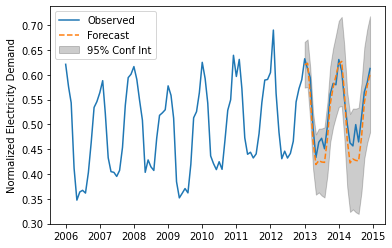

In [64]:
# best hyperparameters from grid search
best_monthly_order = (1,1,1)
best_monthly_seas_order = (0,1,1,12)

# fit SARIMA model
model_m = SARIMAX(train, order=best_monthly_order, seasonal_order=best_monthly_seas_order).fit()

# get forecast and confidence interval for forecast
forecast = model_m.get_forecast(steps=len(validate))
pred = pd.Series(forecast.predicted_mean, index=validate.index)
ci = forecast.conf_int(alpha=0.05)

# plotting
plt.plot(monthly_norm[:'2014'], label='Observed')
plt.plot(pred, label='Forecast', ls='--')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1],
                 color='k', alpha=0.2, label='95% Conf Int')
plt.ylabel('Normalized Electricity Demand')
plt.legend();

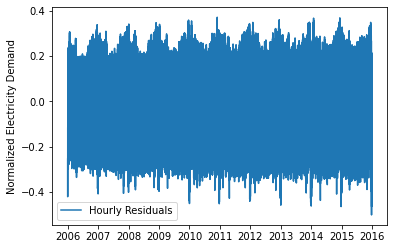

In [65]:
hourly_res_norm = df_norm.copy()
hourly_res_norm['load'] = df_norm['load'].groupby(pd.Grouper(freq='M')).transform(lambda x: x - x.mean())
plt.plot(hourly_res_norm['load'], label='Hourly Residuals')
plt.ylabel('Normalized Electricity Demand')
plt.legend();

In [69]:
# train-validate-test split
train = hourly_res_norm[:'2012']
validate = hourly_res_norm['2013':'2014']
test = hourly_res_norm['2015':]

# setup training variables 
exog_tr = train.iloc[:,1:].values
ar_tr = train['load'].shift().bfill().values[:,None]
X_tr = np.hstack([ar_tr, exog_tr])
y_tr = train['load'].values

# setup validation variables
exog_val = validate.iloc[:,1:].values
y_val = validate['load'].values

# setup testing variables
exog_te = test.iloc[:,1:].values

# setup miscellaneous variables
yp_full = hourly_res_norm.loc[:'2014','load']
yp_val = hourly_res_norm.loc['2013':'2014','load']
yp_te = hourly_res_norm.loc['2015':,'load']
y_init_val = np.hstack([y_tr[-1], validate.iloc[167::168,0].values])
y_init_te = np.hstack([y_val[-1], test.iloc[167::168,0].values])

In [73]:
def compute_mae(y, yhat):
    """given predicted and observed values, computes mean absolute error"""
    return np.mean(np.abs(yhat - y))

def forecast(model, exog, y_init):
    """given a trained model, exogenous features, and initial AR term, makes forecasting predictions"""
    yhat = []
    Xi_te = np.hstack([y_init, exog[0]])[None,:]
    for i in range(len(exog)-1):
        yhat_i = model.predict(Xi_te)[0]
        yhat.append(yhat_i)
        Xi_te = np.hstack([yhat_i, exog[i+1]])[None,:]
    yhat.append(model.predict(Xi_te)[0])
    return np.array(yhat)

def weekly_forecast(model, exog, y_init):
    """given a trained model exogenous features, and initial AR term, makes a series of 1-week-out forecasts"""
    yhat = []
    for i, yi in enumerate(y_init):
        exog_i = exog[168*i:168*(i+1),:]
        if exog_i.shape[0] < 1:
            break
        yhat.append(forecast(model, exog_i, yi))
    return np.hstack(yhat)
    
def plot_full(y, yhat, yhat_idx):
    """plots observed and forecasted values for the full date range"""
    pred = pd.Series(yhat, index=yhat_idx)
    plt.figure()
    plt.plot(y, label='Observed')
    plt.plot(pred, label='Forecast', ls='--')
    plt.ylabel('Normalized Hourly Residual Electricity Demand')
    plt.legend()
    
def plot_week(y, yhat, yhat_idx):
    """plots observed and forecasted values for one week span"""
    pred = pd.Series(yhat, index=yhat_idx)
    fig = plt.figure();
    plt.plot(y['2016-12-01':'2016-12-07'], label='Observed')
    plt.plot(pred['2016-12-01':'2016-12-07'], label='Forecast', ls='--')
    plt.ylabel('Normalized Hourly Residual Electricity Demand')
    plt.legend()
    fig.autofmt_xdate()

MAE: 1.363462593419927e-13


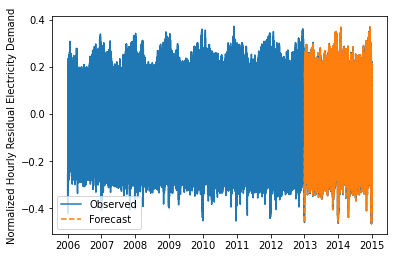

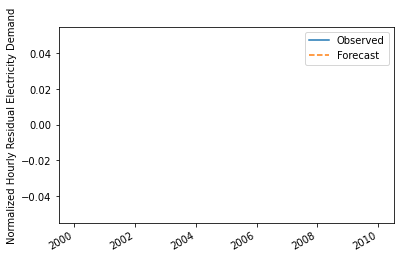

In [74]:
from sklearn.linear_model import LinearRegression

# train model and get predictions
mod_lr = LinearRegression()
mod_lr.fit(X_tr, y_tr)
pred = weekly_forecast(mod_lr, exog_val, y_init_val)

# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)

In [76]:
from sklearn.ensemble import GradientBoostingRegressor

# train GBR model, and get validation set performance
def get_gbr_mae(lr, ne, md):
    mod = GradientBoostingRegressor(learning_rate=lr, n_estimators=ne, max_depth=md)
    mod.fit(X_tr, y_tr)
    pred_val = weekly_forecast(mod, exog_val, y_init_val)
    return compute_mae(y_val, pred_val)

# define potential sets of hyperparameters
learning_rate = [0.01, 0.1, 1.]
n_estimators = [100, 500, 1000]
max_depth = [2, 3, 4]
grid_search = pd.DataFrame(columns=['lr','ne','md','mae'])

# perform grid search
for lr in learning_rate:    
    for ne in n_estimators:        
        for md in max_depth:            
            mae = get_gbr_mae(lr, ne, md)
            params = {'lr':lr, 'ne':ne, 'md':md, 'mae':mae} 
            grid_search = grid_search.append(params, ignore_index=True)

# display best hyperparameters based on grid search
grid_search.sort_values('mae').head(1)

,lr,ne,md,mae
7,0.01,1000.0,3.0,0.000234


MAE: 0.00023379108062665776


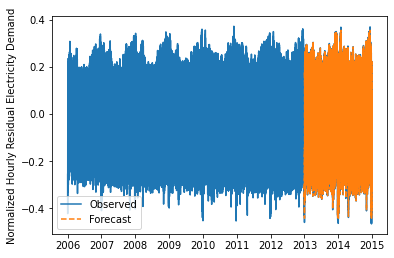

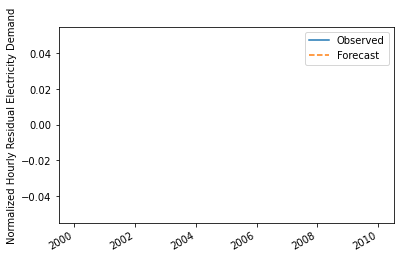

In [77]:
# best hyperparamters
lr, ne, md = 0.01, 1000, 3

# train model and get predictions
mod_gbr = GradientBoostingRegressor(learning_rate=lr, n_estimators=ne, max_depth=md)
mod_gbr.fit(X_tr, y_tr)
pred = weekly_forecast(mod_gbr, exog_val, y_init_val)

# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)

In [90]:
# monthly average forecasts
train_m = monthly_norm[:'2014']
test_m = monthly_norm['2015':]
model_m = SARIMAX(train_m, order=best_monthly_order, seasonal_order=best_monthly_seas_order).fit()
forecast_m = model_m.get_forecast(steps=len(test_m))
pred_m_norm = pd.Series(forecast_m.predicted_mean, index=test_m.index)

In [91]:
pred_lr = weekly_forecast(mod_lr, exog_te, y_init_te)
pred_gbr = weekly_forecast(mod_gbr, exog_te, y_init_te)

In [92]:
m_norm_df = pd.DataFrame({'m_norm':pred_m_norm, 'month':pred_m_norm.index.month, 'year':pred_m_norm.index.year})

In [93]:
# gradient boosting regression: combine monthly/hourly forecasts, unnormalize to original scale
gbr_norm_df = pd.DataFrame({'h_norm':pred_gbr, 'month':test.index.month, 'year':test.index.year})
pred_gbr_norm_df = gbr_norm_df.merge(m_norm_df, on=['month','year'])
pred_gbr_norm = pd.Series((pred_gbr_norm_df['m_norm'] + pred_gbr_norm_df['h_norm']).values, index=test.index)
pred_gbr = pred_gbr_norm * (load_max - load_min) + load_min

In [94]:
# linear regression: combine monthly/hourly forecasts, unnormalize to original scale
pred_lr = weekly_forecast(mod_lr, exog_te, y_init_te)
lr_norm_df = pd.DataFrame({'h_norm':pred_lr, 'month':test.index.month, 'year':test.index.year})
pred_lr_norm_df = lr_norm_df.merge(m_norm_df, on=['month','year'])
pred_lr_norm = pd.Series((pred_lr_norm_df['m_norm'] + pred_lr_norm_df['h_norm']).values, index=test.index)
pred_lr = pred_lr_norm * (load_max - load_min) + load_min

In [96]:
def compute_mape(y, yhat):
    pct_err = ((yhat - y) / y).dropna()
    return np.mean(np.abs(pct_err)) 

print("lin reg MAPE:", compute_mape(load['load'], pred_lr))
print("grad boost reg MAPE:", compute_mape(load['load'], pred_gbr))

lin reg MAPE: 0.02544976622010884
grad boost reg MAPE: 0.025479114776297274


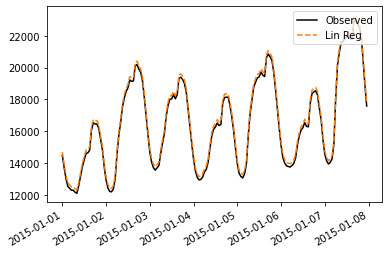

In [99]:
fig, ax = plt.subplots()

ax.plot(load.loc['2015-01-01':'2015-01-07','load'], label='Observed', c='k')
ax.plot(pred_lr['2015-01-01':'2015-01-07'], label='Lin Reg', ls='--', c='C1')
ax.legend(loc=1);

fig.autofmt_xdate()


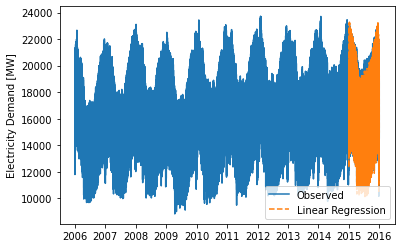

In [102]:
fig = plt.figure()
plt.plot(load.loc[:,'load'], label='Observed')
plt.plot(pred_lr, label='Linear Regression', ls='--')
plt.ylabel('Electricity Demand [MW]')
plt.legend();